In [84]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


In [85]:
X_train = pd.read_csv('train.csv')
X_val = pd.read_csv('val.csv')
X_test = pd.read_csv('test.csv')

X_train.drop(index=X_train[X_train['text'].isna()].index, inplace=True)
X_val.drop(index=X_val[X_val['text'].isna()].index, inplace=True)
X_test.drop(index=X_test[X_test['text'].isna()].index, inplace=True)

y_train = X_train.target
y_val = X_val.target
y_test = X_test.target

In [86]:
my_stop_words = ['wa', 'would', 'ha', 'one', 'get']
tfidfvectorizer = TfidfVectorizer(min_df = 0.001, ngram_range=(1, 2), stop_words=my_stop_words)
tfidf_train = tfidfvectorizer.fit_transform(X_train.text)
tfidf_val = tfidfvectorizer.transform(X_val.text)
tfidf_test = tfidfvectorizer.transform(X_test.text)

In [87]:
word2idx = tfidfvectorizer.vocabulary_
idx2word = [""] * len(word2idx)

for word in word2idx:
    idx2word[word2idx[word]] = word
idx2word = np.array(idx2word, dtype='object')

In [45]:
grid = {
    'max_depth': [5, 10, 50, 100, 200, 300, 350, 360, 370, 375, 400, 450, 500, 550, 600],
    'min_samples_leaf': [1, 3, 5, 7],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

In [46]:
def binarize_target(target, thr):
    return (target > thr).astype(int)


def run_grid_search(est, param_grid, scoring, x_train, y_train, thr):
    y_train_bin = binarize_target(y_train, thr)
    model = GridSearchCV(estimator=est, param_grid=param_grid, scoring=scoring, cv=3, verbose=3)
    model.fit(x_train, y_train_bin)
    return model

def evaluate(model, tfidf_x, y_bin):
    return roc_auc_score(y_bin, model.predict_proba(tfidf_x)[:,1])

In [ ]:
tree05 = run_grid_search(
    est=DecisionTreeClassifier(random_state = 42), 
    param_grid=grid,
    scoring='roc_auc',
    x_train=tfidf_train,
    y_train=y_train,
    thr=0.5
)

In [48]:
tree05.best_params_

{'class_weight': 'balanced',
 'max_depth': 370,
 'max_features': 'sqrt',
 'min_samples_leaf': 7}

In [ ]:
tree04 = run_grid_search(
    est=DecisionTreeClassifier(random_state = 42), 
    param_grid=grid,
    scoring='roc_auc',
    x_train=tfidf_train,
    y_train=y_train,
    thr=0.4
)

In [61]:
tree04.best_params_

{'class_weight': 'balanced',
 'max_depth': 370,
 'max_features': 'sqrt',
 'min_samples_leaf': 7}

In [ ]:
tree06 = run_grid_search(
    est=DecisionTreeClassifier(random_state = 42), 
    param_grid=grid,
    scoring='roc_auc',
    x_train=tfidf_train,
    y_train=y_train,
    thr=0.6
)

In [63]:
tree06.best_params_

{'class_weight': None,
 'max_depth': 370,
 'max_features': 'sqrt',
 'min_samples_leaf': 7}

In [64]:
print("roc-auc on validation with 0.4 thr {:.4f}".format(round(evaluate(tree04, tfidf_val, binarize_target(y_val, 0.4)), 4)))
print("roc-auc on validation with 0.5 thr {:.4f}".format(round(evaluate(tree05, tfidf_val, binarize_target(y_val, 0.5)), 4)))
print("roc-auc on validation with 0.6 thr {:.4f}".format(round(evaluate(tree06, tfidf_val, binarize_target(y_val, 0.6)), 4)))

roc-auc on validation with 0.4 thr 0.8505
roc-auc on validation with 0.5 thr 0.8524
roc-auc on validation with 0.6 thr 0.7896


Результаты при порогах 0.4 и 0.5 очень схожи, на 0.002 значение лучше при 0.5

In [75]:
val_features_id = np.argsort(tree05.best_estimator_.feature_importances_)[-20:][::-1]
importance = tree05.best_estimator_.feature_importances_[val_features_id]
top_words = idx2word[val_features_id]

In [74]:
top_words

array(['damn', 'racist', 'troll', 'garbage', 'ridiculous', 'white',
       'clown', 'black', 'moron', 'liar', 'dumb', 'stupidity',
       'hypocrite', 'crap', 'loser', 'pathetic', 'ignorant', 'fool',
       'idiot', 'stupid'], dtype=object)

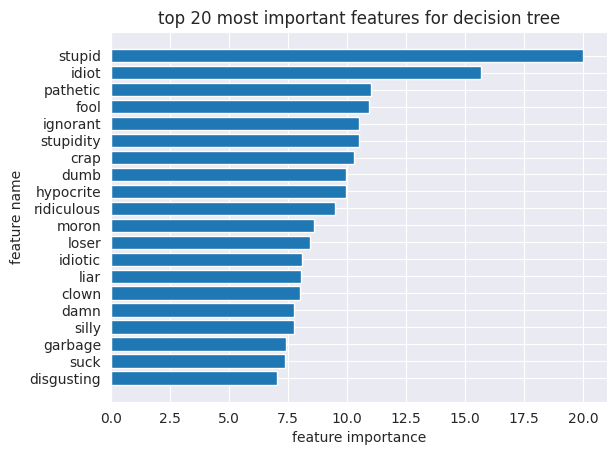

In [93]:
plt.barh(top_words[::-1], importance[::-1])
plt.xlabel('feature importance')
plt.ylabel('feature name')
plt.title('top 20 most important features for decision tree')
plt.show()

In [64]:
gridlog = {
    'penalty': ['l1', 'l2'], 
    'C': np.logspace(-3,3,7), 

}

In [65]:
def binarize_target(target, thr):
    return (target > thr).astype(int)


def run_grid_search(est, param_grid, scoring, x_train, y_train, thr):
    y_train_bin = binarize_target(y_train, thr)
    model = GridSearchCV(estimator=est, param_grid=param_grid, scoring=scoring, cv=3, verbose=3)
    model.fit(x_train, y_train_bin)
    return model

def evaluate(model, tfidf_x, y_bin):
    return roc_auc_score(y_bin, model.predict_proba(tfidf_x)[:,1])

In [ ]:
logreg04 = run_grid_search(
    est= LogisticRegression(), 
    param_grid=gridlog,
    scoring='roc_auc',
    x_train=tfidf_train,
    y_train=y_train,
    thr=0.4
)

In [67]:
logreg04.best_params_

{'C': 1.0, 'penalty': 'l2'}

In [ ]:
logreg05 = run_grid_search(
    est= LogisticRegression(), 
    param_grid=gridlog,
    scoring='roc_auc',
    x_train=tfidf_train,
    y_train=y_train,
    thr=0.5
)

In [21]:
logreg05.best_params_

{'C': 1.0, 'penalty': 'l2'}

In [ ]:
logreg06 = run_grid_search(
    est= LogisticRegression(), 
    param_grid=gridlog,
    scoring='roc_auc',
    x_train=tfidf_train,
    y_train=y_train,
    thr=0.6
)

In [23]:
logreg06.best_params_

{'C': 1.0, 'penalty': 'l2'}

In [24]:
print("roc-auc on validation with 0.4 thr {:.4f}".format(round(evaluate(logreg04, tfidf_val, binarize_target(y_val, 0.4)), 4)))
print("roc-auc on validation with 0.5 thr {:.4f}".format(round(evaluate(logreg05, tfidf_val, binarize_target(y_val, 0.5)), 4)))
print("roc-auc on validation with 0.6 thr {:.4f}".format(round(evaluate(logreg06, tfidf_val, binarize_target(y_val, 0.6)), 4)))

roc-auc on validation with 0.4 thr 0.9317
roc-auc on validation with 0.5 thr 0.9306
roc-auc on validation with 0.6 thr 0.8686


Результаты при порогах 0.4 и 0.5 схожи, на 0.001 значение лучше при 0.4

In [78]:
val_features_id_logreg = np.argsort(logreg04.best_estimator_.coef_[0])[-20:][::-1]
importance = logreg04.best_estimator_.coef_[0][val_features_id_logreg]
top_words = idx2word[val_features_id_logreg]
top_words

array(['stupid', 'idiot', 'pathetic', 'fool', 'ignorant', 'stupidity',
       'crap', 'dumb', 'hypocrite', 'ridiculous', 'moron', 'loser',
       'idiotic', 'liar', 'clown', 'damn', 'silly', 'garbage', 'suck',
       'disgusting'], dtype=object)

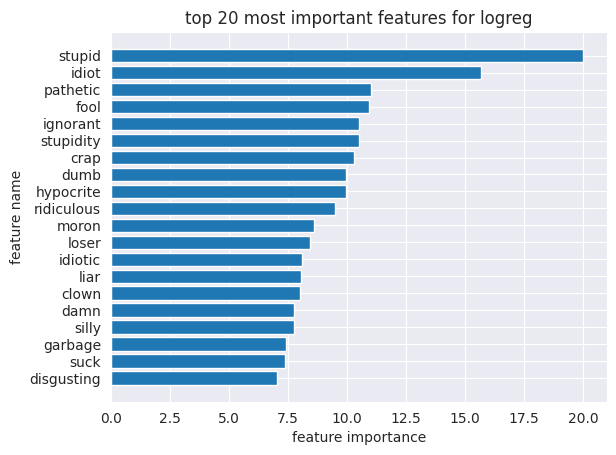

In [94]:
plt.barh(top_words[::-1], importance[::-1])
plt.xlabel('feature importance')
plt.ylabel('feature name')
plt.title('top 20 most important features for logreg')
plt.show()

In [88]:
thr = 0.4
y_train_bin = binarize_target(y_train, thr)
y_val_bin = binarize_target(y_val, thr)
y_test_bin = binarize_target(y_test, thr)

In [26]:
%%timeit -n 3 -r 5
best_rfc = DecisionTreeClassifier(max_depth = 200, class_weight='balanced', max_features = 'sqrt',
 min_samples_leaf= 7).fit(tfidf_train, y_train_bin)

203 ms ± 7.46 ms per loop (mean ± std. dev. of 5 runs, 3 loops each)


In [27]:
best_rfc = DecisionTreeClassifier(max_depth = 200, class_weight='balanced', max_features = 'sqrt',
 min_samples_leaf= 7).fit(tfidf_train, y_train_bin)

In [28]:
%%timeit 
best_rfc.predict_proba(tfidf_train)

14.6 ms ± 895 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [89]:
%%timeit -n 3 -r 5
best_rfc = LogisticRegression(C= 1.0, penalty = 'l2').fit(tfidf_train, y_train_bin)

363 ms ± 93.2 ms per loop (mean ± std. dev. of 5 runs, 3 loops each)


In [90]:
best_rfc = LogisticRegression(C= 1.0, penalty = 'l2').fit(tfidf_train, y_train_bin)

In [91]:
%%timeit 
best_rfc.predict_proba(tfidf_train)

2.12 ms ± 69.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Наилучший результат показала логистическая регрессия, roc-auc равен 0,9317